In [5]:
import findspark
findspark.init()
import pyspark
import random
sc = pyspark.SparkContext()


In [20]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

# Load Minute Weather Data

In [6]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:///data/workshop/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [7]:
df.count()

1587257

In [8]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [9]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.8301614102255,3.0517165528303907,905.0,929.5
air_temp,158726,61.85158915363571,11.83356921064164,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905914,0.0,359.0
avg_wind_speed,158680,2.775214897907739,2.057623969742644,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838698,0.0,359.0
max_wind_speed,158680,3.400557726241481,2.4188016208098895,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784561,0.0,359.0
min_wind_speed,158680,2.1346641038568106,1.742112505242439,0.0,31.6


In [10]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

157812

In [11]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count() 

157237

# Remove unused and missing data

In [12]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [13]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [14]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [15]:
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

# Scale the data so that the mean is 0

In [16]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [17]:
scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

# Create elbow plot to determine number of clusters

In [21]:
clusters = range(2,31)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 114998.41184838113 
Training for cluster size 3 
......................WSSE = 103473.50376582553 
Training for cluster size 4 
......................WSSE = 94582.73153945802 
Training for cluster size 5 
......................WSSE = 91130.38687644119 
Training for cluster size 6 
......................WSSE = 84756.71281394702 
Training for cluster size 7 
......................WSSE = 82298.68664126359 
Training for cluster size 8 
......................WSSE = 78463.8677478112 
Training for cluster size 9 
......................WSSE = 76037.02089689198 
Training for cluster size 10 
......................WSSE = 73933.75370059752 
Training for cluster size 11 
......................WSSE = 72984.24004771381 
Training for cluster size 12 
......................WSSE = 71565.17836697878 
Training for cluster size 13 
......................WSSE = 69396.03011205287 
Training for cluster size 14 
......................WSSE = 69328.669369

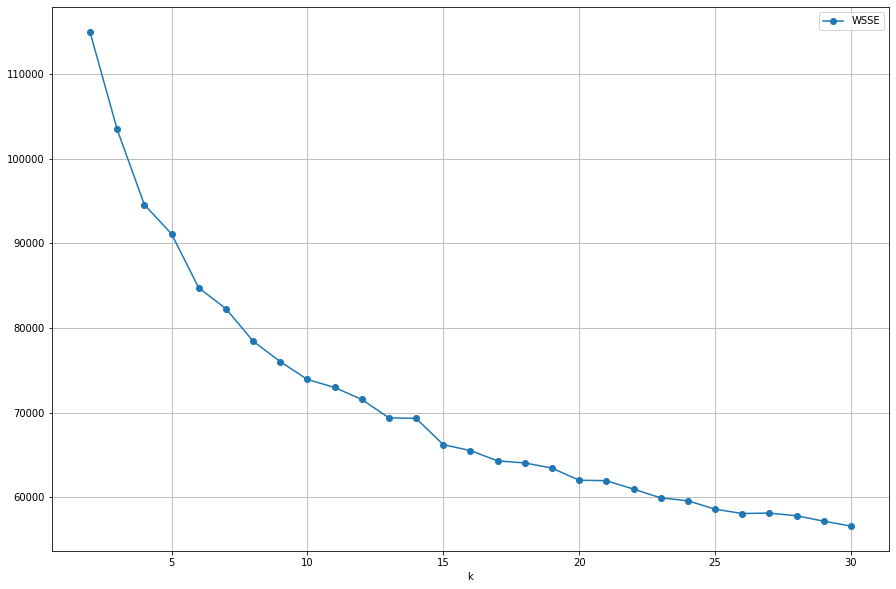

In [22]:
utils.elbow_plot(wsseList, clusters)

In [23]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

# Cluster the data using k-means

In [24]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [25]:
centers = model.clusterCenters()
centers

[array([ 0.11388038,  0.87986759,  1.40176772, -0.6364078 ,  1.66546402,
        -0.58712956, -0.72255134]),
 array([ 0.24659758, -0.98935448,  0.6788667 , -0.56871543,  0.87374612,
        -0.55008715,  1.16446991]),
 array([ 1.35717292, -0.08012563, -1.2107241 , -0.06190118, -1.07909746,
        -0.04254358, -0.97266237]),
 array([-0.62391035,  0.60425913,  0.18216423, -0.59883944,  0.3531729 ,
        -0.61237635, -0.17732402]),
 array([ 0.83627553,  0.30074411,  0.3134918 , -0.50843372,  0.50089194,
        -0.51299775, -0.76267787]),
 array([ 0.04867874, -0.78851564, -1.19228238, -0.57077256, -1.03768472,
        -0.58519195,  0.88437328]),
 array([-0.1672974 ,  0.86423773, -1.30784626, -0.59040159, -1.16341861,
        -0.60581476, -0.63728623]),
 array([-0.22450118,  0.63890717,  0.40790205,  0.73334891,  0.51595857,
         0.67123706, -0.14853343]),
 array([ 1.19124344, -0.25324765, -1.15504087,  2.11458721, -1.05313094,
         2.23166515, -1.13472511]),
 array([-1.18245358

# Generate parallel plots to analyze clusters

In [26]:
P = utils.pd_centers(featuresUsed, centers)

## Dry Days

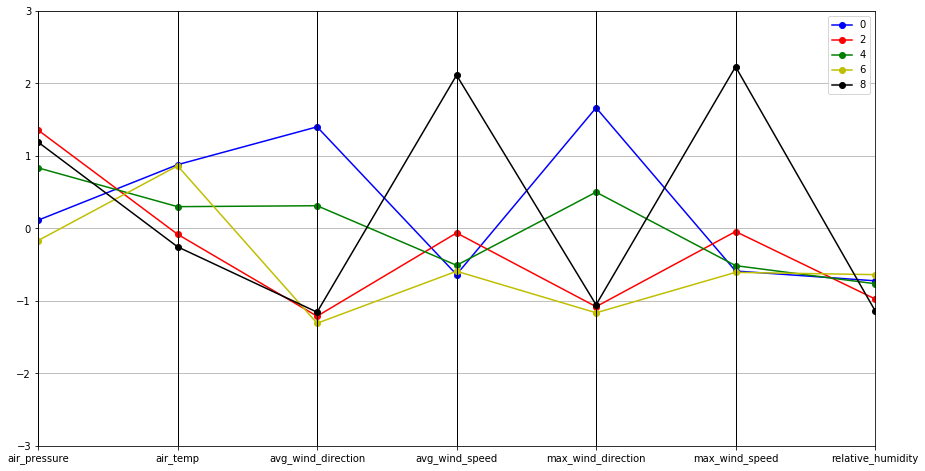

In [27]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

## Warm Days

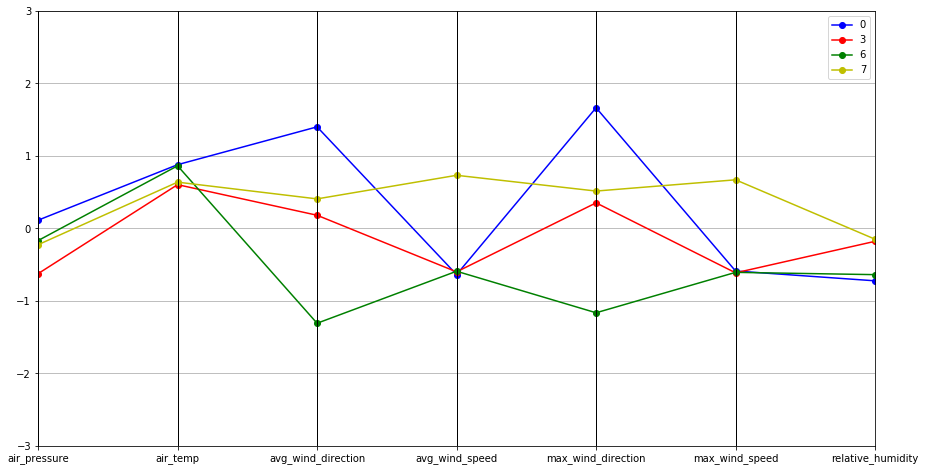

In [28]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

## Cool Days

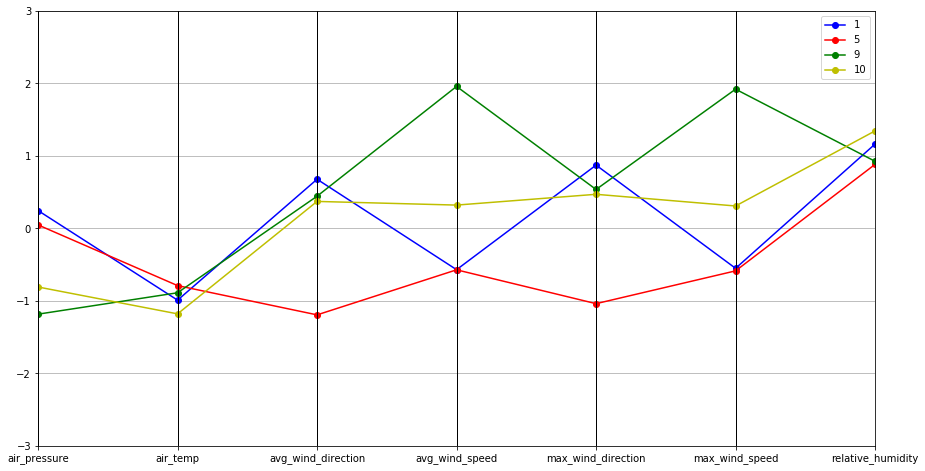

In [29]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

## Other Days

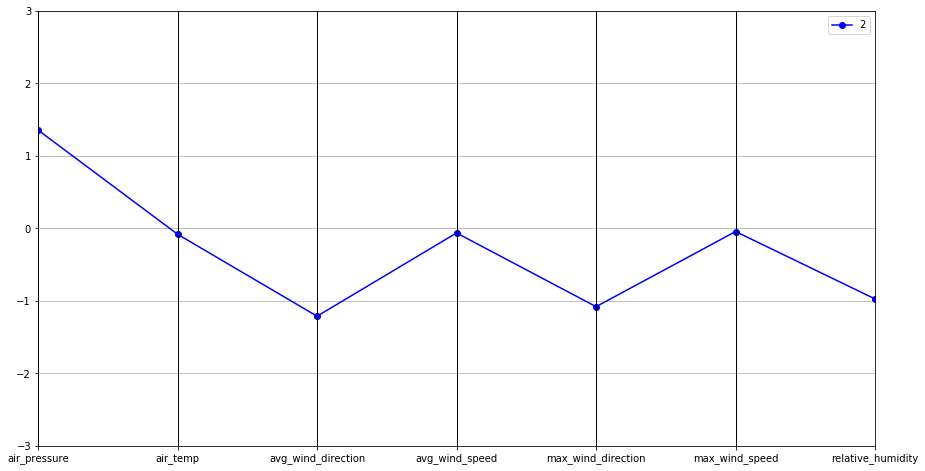

In [30]:
utils.parallel_plot(P.iloc[[2]], P)